<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/ArbitraryTimeSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [17]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil
import sympy as sp

clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [18]:
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py

from DmriFemBuitInFunc import *

class MRI_parameters():
    def __init__(self):
        # Initialize default parameters
        self.bvalue = None
        self.qvalue = None        
        self.gdir = [1, 0, 0];
        self.nperiod = 0; # number of period for OGSE sequences
        self.T2 = 1e16    # T2 relaxation time        
    def set_gradient_dir(self, mymesh, g0, g1, g2):
        gdim = mymesh.geometry().dim()
        if gdim==2:
            self.gdir = Point(g0, g1)
            self.gdir /= self.gdir.norm()
            self.g = Expression(("g0","g1"), g0=self.gdir.x(), g1=self.gdir.y(),domain=mymesh, degree=1);
        if gdim==3:
            self.gdir = Point(g0, g1, g2)
            self.gdir /= self.gdir.norm()        
            self.g = Expression(("g0","g1","g2"), g0=self.gdir.x(), g1=self.gdir.y(), g2=self.gdir.z(),domain=mymesh, degree=1);
            
    def time_profile_sym(self):
        self.T = self.Delta+self.delta;
        # Return symbolic f(s)
        s = sp.Symbol('s')
        seq_choice = 2
        
        if seq_choice == 1:
            # PGSE
            self.fs_sym = sp.Piecewise(
                (  1., s < self.delta ),
                (  0., s < self.Delta ),
                ( -1., s < self.Delta + self.delta ),
                (  0., True )  
            ) 
        if seq_choice == 2:    
            # cos-OGSE
            if self.nperiod == 0:
                print('Number of periods should be larger than 0 for this OGSE sequence!');
                sys.exit() 
            omega = 2.0*self.nperiod*pi/self.delta                    
            self.fs_sym = sp.Piecewise(
                (  sp.cos(omega*s) , s < self.delta ),
                (  0., s < self.Delta ),
                (  -sp.cos(omega*(s-2.*self.delta)), s < self.Delta + self.delta ),
                (  0., True )  
            )
        if seq_choice == 3:    
            # sin-OGSE
            if self.nperiod == 0:
                print('Number of periods should be larger than 0 for this OGSE sequence!');
                sys.exit() 
            omega = 2.0*self.nperiod*pi/self.delta    
            self.fs_sym = sp.Piecewise(
                (  sp.sin(omega*s) , s < self.delta ),
                (  0., s < self.Delta ),
                (  -sp.sin(omega*(s-2.*self.delta)/self.delta), s < self.Delta + self.delta ),
                (  0., True )  
            )                
    def integral_term_for_gb(self):
        u = sp.Symbol('u') 
        s = sp.Symbol('s')         
        int_fs_u_T = sp.integrate(self.fs_sym, (s, u, self.T))
        self.int4gb = float(sp.integrate(int_fs_u_T*int_fs_u_T, (u, 0, self.T)))

    def itime_profile_sym(self):
        # Return symbolic int_0^s f(u) du, change variable to ift(s)
        s = sp.Symbol('s')
        u = sp.Symbol('u')
        self.ifs_sym = sp.integrate(self.fs_sym.subs(s, u), (u, 0, s))
        
    def time_profile(self, t):
        s = sp.Symbol('s')       
        return (float(self.fs_sym.subs(s,t)))
      
    def itime_profile(self, t): 
        s = sp.Symbol('s')       
        return (float(self.ifs_sym.subs(s, t)))

    def convert_b2g(self):
        self.gnorm = 0;
        self.gnorm = sqrt(self.bvalue)/sqrt(self.int4gb);
        return self.gnorm
    def convert_g2b(self):
        self.bvalue = self.gnorm*self.gnorm*self.int4gb;
        return self.bvalue
      
    def Apply(self):
        self.time_profile_sym();        
        self.itime_profile_sym(); 
        self.integral_term_for_gb();
        if not(self.bvalue==None):
            self.gnorm = self.convert_b2g();
            self.qvalue = convert_g2q(self.gnorm);
        elif not(self.qvalue==None):
            self.gnorm = convert_q2g(self.qvalue);
            self.bvalue = self.convert_g2b();
        elif (self.bvalue==None and self.bvalue==None):
            print("bvalue or qvalue need to be specified.")
            sys.exit()      
          
class MRI_simulation():
    def __init__(self):
          self.nskip = 5;    # Output frequency (for visualization only)
          self.theta = 0.5;  # theta=0.5: midpoint method

    def InitialCondition(self, mydomain):
          if mydomain.gdim==2:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          if mydomain.gdim==3:
              Dirac_Delta = Expression("x[0]*x[0]+x[1]*x[1]+x[2]*x[2]<eps",eps=1e6, domain=mydomain.mymesh, degree=1);
          Dirac_Delta = interpolate(Dirac_Delta, mydomain.V);
          u_0 = Function(mydomain.W);
          assign(u_0.sub(0), Dirac_Delta)
          if (mydomain.IsDomainMultiple==True):
              assign(u_0.sub(2), Dirac_Delta)  
          return Dirac_Delta, u_0
        
    def solve(self, mydomain, mri_para, linsolver): 
      
          self.Dirac_Delta, self.u_0 = self.InitialCondition(mydomain)
          
          stepcounter = 0;

          M = MassMatrix(mydomain);

          self.t = 0;
          ft_prev  =  mri_para.time_profile(self.t);
          ift_prev = mri_para.itime_profile(self.t);

          start_time = time.time()
          
          while self.t < mri_para.T + self.k: # Time-stepping loop
              if stepcounter % self.nskip == 0:
                  print('t: %6.2f '%self.t, 'T: %6.2f'%mri_para.T, 'dt: %.1f'%self.k,'gnorm: %e'%mri_para.gnorm,'Completed %3.2f%%'%(float(self.t)/float(mri_para.T+mri_simu.k)*100.0));

              ft = mri_para.time_profile(self.t);
              ift = mri_para.itime_profile(self.t);
                            
              L = ThetaMethodL(ft_prev, ift_prev, mri_para, self, mydomain);
              A = 1/self.k*M + assemble(ThetaMethodF(ft, ift, mri_para, self, mydomain))

              b = assemble(L);
              
              linsolver.solve(A, self.u_0.vector(),b);

              ft_prev  = ft;
              ift_prev = ift;

              self.t += self.k;
              stepcounter += 1;

          self.elapsed_time = time.time() - start_time
          print("Successfully Completed! Elapsed time: %f seconds"%self.elapsed_time)
          
def Post_processing(mydomain, mri_sim, ms=''):
    one = Function(mydomain.V)
    one.vector()[:] = 1
    whole_vol = assemble(one*dx)
    voi = assemble(mri_simu.Dirac_Delta*dx)
    if mydomain.IsDomainMultiple == True:
        u0r_0, u0i_0, u1r_0, u1i_0 = split(mri_simu.u_0)
        signal0 = assemble(((1-mydomain.phase)*u0r_0)*dx)/assemble((1-mydomain.phase)*mri_simu.Dirac_Delta*dx);
        signal1 = assemble((mydomain.phase*u1r_0)*dx)/assemble(mydomain.phase*mri_simu.Dirac_Delta*dx);
        signal = assemble((mydomain.phase*u1r_0+(1-mydomain.phase)*u0r_0)*dx);
        print('Signal on each compartment')
        print('Signal0: %.3e'%signal0)
        print('Signal1: %.3e'%signal1)
        out_text = 'b: %.3f, Signal: %.3e, Normalized signal: %.3e, kappa: %.3e, dt: %.3f, hmin: %.3f, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, signal, signal/voi, mydomain.kappa, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*D0), mri_sim.elapsed_time)
        V0 = FunctionSpace(mesh0, mydomain.Ve);
        V1 = FunctionSpace(mesh1, mydomain.Ve);
        u0r_0p = project(u0r_0,V0)
        u1r_0p = project(u1r_0,V1)
        plot(u0r_0p, cmap="coolwarm")
        plot(u1r_0p, cmap="coolwarm")  
        File("u0r.pvd")<<u0r_0p
        File("u1r.pvd")<<u1r_0p
    else:
        ur, ui = split(mri_simu.u_0)
        signal = assemble(ur*dx);
        out_text = 'b: %.3f, Signal: %.3e, Normalized signal: %.3e, dt: %.3f, hmin: %.3e, whole_vol: %.3f, vol_of_interest: %.3f, Free signal: %.3e, elasped time %.3f (s)\n'%(mri_para.bvalue, signal, signal/voi, mri_simu.k, mydomain.hmin, whole_vol, voi, exp(-mri_para.bvalue*D0), mri_sim.elapsed_time)
        V = FunctionSpace(mymesh,mydomain.Ve);
        ur_p = project(ur,V)
        plot(ur_p, cmap="coolwarm")
        File("ur.pvd")<<ur_p

    print(out_text)
    print("save to log.txt")
    outfile = open('log.txt', 'a')
    if not(ms == ''):
        outfile.write('%'+ms+'\n')
    outfile.write(out_text)
    outfile.close()  

Load pre-defined functions from GitHub


# Working on the mesh

Topological dimension:  2
Geometrical dimension:  2
Mesh size: #vertices: 256, #elements: 450


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


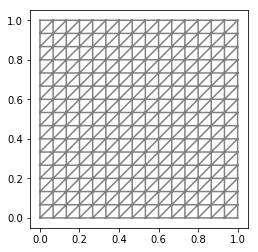

In [19]:
# domain = Circle(Point(0.,0.),5.0,60)
# mymesh = generate_mesh(domain, 15, "cgal")
mymesh = UnitSquareMesh(15, 15)
gdim = mymesh.geometry().dim()
tdim = mymesh.topology().dim()

print('Topological dimension: ',tdim)
print('Geometrical dimension: ',gdim)
print('Mesh size: #vertices: '+str(mymesh.num_vertices()) +', #elements: '+str(mymesh.num_cells()) );
plot(mymesh)

# Solve the Bloch-Torrey equation

In [0]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.bvalue = 1000;                              # bvalue
mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
mri_para.nperiod = 1
mri_para.set_gradient_dir(mymesh, 0, 1, 0)           # gradient direction
mri_para.Apply()
mri_simu.k = 100;                                    # time-step size
mri_simu.nskip = 1;                                  # frequency to print ouputs
mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = None
mydomain.PeriodicDir = [0, 1, 0];             # Direction of the periodicity
mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                         # Permeability
################################################################################
mydomain.Apply()   # Call Apply before setting the diffusion tensor
################################################################################
# Impose the diffusion coefficient
D0 = 3e-3
mydomain.D = D0;
#################################################################################

mri_simu.solve(mydomain, mri_para, PETScLUSolver("mumps"))

Post_processing(mydomain, mri_simu)
# Post_processing(mydomain, mri_simu,'Extracellular Simulation')

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
The pseudo-periodic BCS are weakly imposed.
The mesh does not need to be periodic.
t:   0.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.00%
t: 100.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.19%
t: 200.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.37%
t: 300.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.56%
t: 400.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.74%
t: 500.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 0.93%
t: 600.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 1.12%
t: 700.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 1.30%
t: 800.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 1.49%
t: 900.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 1.67%
t: 1000.00  T: 53700.00 dt: 100.0 gnorm: 1.688585e-04 Completed 1.86%
t: 1100.00  T: 53700.00 dt: 100.0 gnor